# Depth Estimator Example

The following tutorial is meant as a quick intro to Kalman Filtering. We will assume you know the general theory. Now, let's put this knowledge into action and produce some actual code!

We will consider the case of estimating an underwater robot's depth. For this purpose, the robot is equipped with a pressure sensor, providing us with (noisy) 
pressure data.

The following figure depicts our robot in a body of water. Following the ROS coordinate frame conventions, we will define a map frame with $z$-axis pointing upwards. Furthermore, the origin lies on the water surface. Therefore, we expect negative $z$-values when the robot is submerged. The dashed line shows the pressure sensor's vertical position.

<center><img src="figs/depth_estimator_example.png" width="400">




## Choice of system states

First, we should think about what states we might want or need to estimate. While the fluid pressure gives us information about the robot's depth, without any further sensors, we cannot infer the x- and y-position. Therefore, the obvious choice would be just including the $z$-coordinate, resulting in

$$x=\begin{bmatrix}z\end{bmatrix}.$$

However, it might make sense to include the velocity in $z$-direction as well. We'll come to this in a bit. For now, let's directly start with

$$\bm{x}=\begin{bmatrix}x_1\\x_2\end{bmatrix}=\begin{bmatrix}z\\v_z\end{bmatrix}.$$

Regarding notation, since in state estimation, the measurement is usually denoted by $\bm{z}$, we will stick to $\bm{x}=\begin{bmatrix}x_1\\x_2\end{bmatrix}$.

## Prediction step and choice of process function

The process function is used for propagating the estimated state into the future. This comes in handy when we receive measurements with a low frequency, one that is too low for feedback control. 
However, note that the Kalman filter is not able to magically foresee the future. We will still need to receive measurements to gain information on our state!

This process function can be based e. g. on a physical model. However, in real life we seldom have accurate models of our physical systems. Therefore, we recommend to start simple.

**We will see that you do not actually need the "correct" physical model.**


### The most simple approach

What is the most simple process model you can think of?  
Right, let's assume nothing changes at all between time steps, i.e. new state = old state, resulting in 

$$\bm{x}(k+1) = f(\bm{x}(k)) = \bm{x}(k). $$

For our 2-dimensional state, we can express this as

$$f(\bm{x}) = \bm{A} \cdot \bm{x},$$
with $\bm{A}=\begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}$.

You can try this and you will see that in a lot of cases, this is already sufficient.

### Using a constant velocity model

However, we recommend using a simple constant velocity model.
Here, we use our velocity estimate at hand to propagate our depth estimate. Assuming constant velocity inbetween time steps, we get

$$\bm{x}(k+1) = f(\bm{x}) = \begin{bmatrix}x_1(k) + dt \cdot x_2(k) \\ x_2(k)\end{bmatrix}.$$

Taking the Jacobian of this function results in

$$\bm{A}= \begin{bmatrix}1 & dt\\0 & 1\end{bmatrix}.$$

We will see in the coding example that by using this process model, we get the velocity estimates "for free", without actually measuring any velocity data! Maybe the Kalman filter is magic, afterall?


## Update step and choice of measurement function

Next, we need to model the measurement. Let's think about the physical relationship between pressure and depth

$$p=\rho g h + p_0,$$

where $\rho$ is the fluid's density, $g$ is the graviational acceleration, $h$ is the height of the fluid column, and $p_0$ is the atmospheric pressure.

However, for our Kalman filter, we need a measurement function $h(\bm{x})$ describing the expected measurement given our states.
Given a certain depth $x_1$, what is the pressure we expect to measure?
Solving the equation above for the height of the fluid column results in
$$\bm{z} = h(\bm{x})= p_0 + \rho g (-x_1) $$

Taking the Jacobian, we get

$$\bm{H}= \begin{bmatrix}-\rho g & 0\end{bmatrix}$$

In the following, we will approximate $\rho g$ with $10^4$.


# Kalman filter equations

We have thought about our process and measurement model. Now, let's have a look at the Kalman filter equations. Although in this case our system is linear, we will directly look at the Extended Kalman filter. Applying the Extended Kalman filter to a linear system results in a linear Kalman filter!

There are many different notations out there, let's stick to Wikipedia in this tutorial. Wikipedia's always correct, right? The equations can be found here: https://en.wikipedia.org/wiki/Extended_Kalman_filter#Discrete-time_predict_and_update_equations 


<center><img src="figs/ekf_equations_wikipedia.png" width="800"></center>

We note a few differences: What we called the $\bm{A}$-matrix so far is called $\bm{F}$ here, so let's stick to that.
Additionally, the process model here includes the control input $\bm{u}$. For simplicity reasons, we highly recommend not including the control input in the prediction.

### Notation

The notation is explained in the Wikipedia article on the [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter#Underlying_dynamic_system_model).



# Implementation

It's time to put these equations into code!
We're starting with a few general definitions:

In [13]:
import numpy as np

np.random.seed(1)  # for repeatability

atmospheric_pressure = 101300  # in Pa
dim_state = 2
dim_measurement = 1

t_end = 20  # in s
dt = 0.1  # updating at 10 hz
t = np.arange(start=0, stop=t_end, step=dt)  # time vector for our time simulation

## Values to play around with

In the following, we define parameters used for our Kalman filter. Change these parameters to see the effect on our estimation performance!

### Initial state and variance 
We need to initialize our estimate somewhere. A common choice is zero for all states. How sure are we about our initial guess?

In [14]:
x0_est = np.array([[0], [0]])  # initial guess for our states

depth_initial_std_dev = 0.5  # in m
depth_velocity_initial_std_dev = 0.5   # in m/s

P0 = np.array([[depth_initial_std_dev ** 2, 0], [0, depth_velocity_initial_std_dev ** 2]])  # covariance of initial guess

### Process noise
How much is uncertainty increasing each process step? In reality, this is a tuning parameter.

It might make sense to have this covariance $Q$ depend on the $dt$ between prediction steps...

In [15]:
depth_std_dev = 0.001  # in m   # 0.001
depth_velocity_std_dev = 0.1  # in m/s   # 0.1
Q = np.diag([depth_std_dev ** 2, depth_velocity_std_dev ** 2])

### Measurement noise
How much do we trust the measurements? This is also a tuning parameter.

In [16]:
pressure_std_dev = 500  # in Pa
R = np.array([pressure_std_dev ** 2]).reshape((-1, 1))

### Probability that a measurement is lost
We will add this to show what happens when long times between measurement updates pass. 

In [17]:
drop_measurement_probability = 0.2

### *Real* system dynamics and measurement noise

We need to simulate the system we want to observe. Normally, this would be done by our simulation environment, i.e. Gazebo, or the real world.

As an example, we will have a sinusoidal movement around the true initial depth position.
We will assume perfect dynamics. However, we will make the measurements noisy. You can try out different amounts of noise. 

The Kalman Filter is the optimal state estimator for linear systems with *Gaussian* noise - it would be interesting to try out the effect of other noise distributions!


In [18]:
# initialize values
scaling = 0.2
x0_true = np.array([[-1], [scaling]])

# true measurement noise used for computation of received measurements
pressure_std_dev_true = 500  # Pascal

def true_system_dynamics(t):
    # oscillating around initial depth
    return np.array([[scaling * np.sin(t) + x0_true[0, 0]], [scaling * np.cos(t)]])

def true_meas_function(x):
    # add zero-mean noise, doesn't have to be Gaussian - would be fun to try out other distributions!
    noise = np.random.normal(0, pressure_std_dev_true)
    return -x[0, 0] * 1.0e4 + atmospheric_pressure + noise

## Function definitions
The heart of our Kalman Filter. These lines implement the Kalman filter equations from above.

In [19]:
def h_fun(depth):
    return -depth * 1.0e4 + atmospheric_pressure

def get_h_jacobian():
    return np.array([-1.0e4, 0.0]).reshape((1, -1))

def f_fun(dt, x_est):
    return np.array([x_est[0,0] + dt * x_est[1,0], x_est[1,0]]).reshape((-1,1))

def get_f_jacobian(dt):
    return np.array([[1, dt], [0, 1]])
    
def predict(dt, x_est, P):
    """ invoke this function each time step to propagate the state """
    x_est_new = f_fun(dt, x_est)
    f_jacobian = get_f_jacobian(dt)
    P_new = np.matmul(np.matmul(f_jacobian, P), f_jacobian.transpose()) + Q
    return x_est_new, P_new

def update(z, x_est, P):
    """ invoke this function each time a new measurement is received """
    h_jacobian = get_h_jacobian()
    
    # estimated pressure measurement
    z_est = h_fun(x_est[0, 0])
    
    # innovation
    y = np.asarray(z - z_est).reshape((-1,1))
    
    # compute Kalman gain
    S = np.matmul(np.matmul(h_jacobian, P), h_jacobian.transpose()) + R   # innovation covariance
    K = np.matmul(np.matmul(P, h_jacobian.transpose()), np.linalg.inv(S))
    
    # update state
    x_est_new = x_est + np.matmul(K, y)
    
    # update covariance
    P_new = np.matmul(np.eye(dim_state) - np.matmul(K, h_jacobian), P)
    return x_est_new, P_new, K

## Book-keeping for plotting
Saving our estimates in order to make nice plots later! **You can ignore this block, it's purely for data storage. It does not have anything to do with State Estimation Implementation.** 

In [20]:
def new_book_keeping():
    x_true_all = np.zeros([dim_state, t.size])
    x_est_all = np.zeros([dim_state, t.size])
    P_all = np.zeros([dim_state, t.size])  # we'll only store the diagonal
    meas_all = np.zeros([dim_measurement, t.size])
    meas_received_all = np.zeros([dim_measurement, t.size])

    # store initial values
    x_true_all[:, 0] = x0_true[:, 0]
    x_est_all[:, 0] = x0_est[:, 0]
    P_all[:, 0] = np.diag(P0)
    meas_all[:, 0] = np.NaN
    meas_received_all[:, 0] = np.NaN
    return x_true_all, x_est_all, P_all, meas_all, meas_received_all

## Let's simulate!

We will wrap the time simulation in a function so we can easily try out other values later on.

In [21]:
def time_simulation():
    # initialize variables for data storing
    x_true_all, x_est_all, P_all, meas_all, meas_received_all = new_book_keeping() 

    x_est = x0_est
    P = P0
    t_last = 0

    for idx, t_now in enumerate(t[1:,]):
        
        ## True system dynamics - this step is normally done by simulation environment/real world
        x_true = true_system_dynamics(t_now)
            
        ## Process step - propagating estimated state
        dt_ =  t_now - t_last  # compute actual time difference since last prediction
        t_last = t_now
        x_est_next, P_next = predict(dt_, x_est, P)
        
        # Do we get a measurement?
        if (np.random.uniform() > drop_measurement_probability):
            # Generating (noisy) measurement - also normally done by simulation environment/real sensor
            z_true = true_meas_function(x_true)
            
            ## Measurement update - finally fuse some measurements :-)
            x_est_next, P_next, K = update(z_true, x_est_next, P_next)

            meas_received_all[:, idx+1] = get_measured_depth(z_true)
        else:
            # no measurement received :-(
            meas_received_all[:, idx+1] = np.NaN
        
        # save variables for plotting
        x_true_all[:, idx+1] = x_true.reshape(-1)
        x_est_all[:, idx+1] = x_est_next.reshape(-1)
        P_all[:, idx+1] = np.diag(P)
        
        x_est, P = x_est_next, P_next

    return x_true_all, x_est_all, P_all, meas_all, meas_received_all


def get_measured_depth(pressure_meas):
    return - (pressure_meas - atmospheric_pressure) / 1.0e4

In [22]:

x_true_all, x_est_all, P_all, meas_all, meas_received_all = time_simulation()

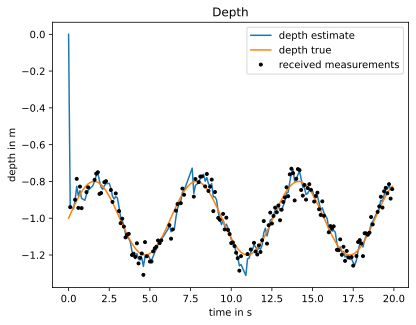

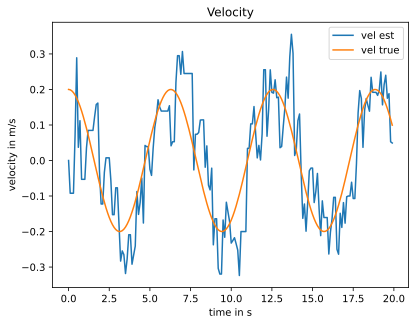

In [23]:
# visualization
import matplotlib.pyplot as plt

# render plots as vector graphics to avoid ugly, blury plots
%config InlineBackend.figure_formats = ['svg']

plt.figure()
plt.title('Depth')
plt.xlabel('time in s')
plt.ylabel('depth in m')
plt.plot(t, x_est_all[0, :], label='depth estimate')
plt.plot(t, x_true_all[0, :], label='depth true')
plt.plot(t, meas_received_all[0, :], '.k', label='received measurements')
plt.legend(loc='upper right')

plt.figure()
plt.title('Velocity')
plt.xlabel('time in s')
plt.ylabel('velocity in m/s')
plt.plot(t, x_est_all[1, :], label='vel est')
plt.plot(t, x_true_all[1, :], label='vel true')
plt.legend(loc='upper right')

plt.show()

## Comparison with Moving Average Filter

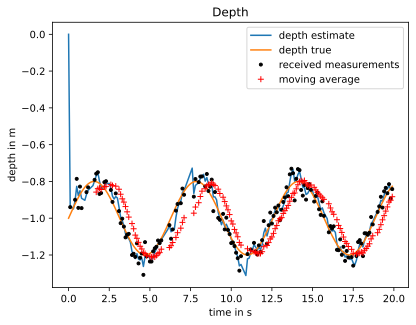

In [24]:
import pandas as pd

plt.figure()
plt.title('Depth')
plt.xlabel('time in s')
plt.ylabel('depth in m')
plt.plot(t, x_est_all[0, :], label='depth estimate')
plt.plot(t, x_true_all[0, :], label='depth true')
plt.plot(t, meas_received_all[0, :], '.k', label='received measurements')

# for comparison: moving average filter in post-processing
t_ma = t[~np.isnan(meas_received_all[0, :])]
m = meas_received_all[0, :][~np.isnan(meas_received_all[0, :])]
moving_average = pd.Series(m).rolling(window=10).mean()
plt.plot(t_ma, moving_average, '+r', label='moving average')

plt.legend(loc='upper right')

plt.show()

In [25]:
# berechnete Tiefe aus Druckmessung -> mit plotten

# stufenweise bei velocity - weil wir ja konstante Geschwindigkeit annehme!
# - updaten von velocity nur bei neuer Messung - wird im Process model gar nicht geändert

## Was möchte Lennart, was du mitnimmst? - Kalman filtering is easy! (for simple cases)

# equations aren't very complex

## Looking at variance
We are not only estimating the system's states. The Kalman filter also provides us with an estimate of these states' uncertainty. Let's have a look!

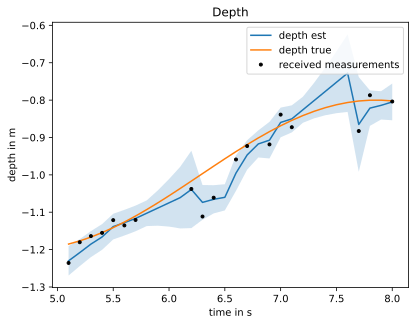

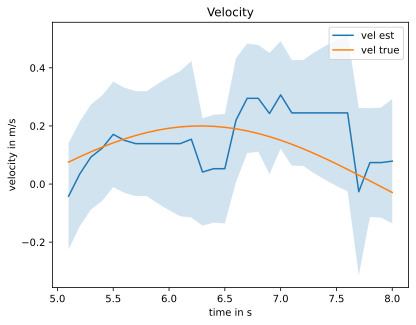

In [26]:
# Varianz mit anschauen
# -> +- standard abweichung um mean plotten

idx_start = int(np.argwhere(t>5)[0])
idx_stop = int(np.argwhere(t>8)[0])


plt.figure()
plt.title('Depth')
plt.xlabel('time in s')
plt.ylabel('depth in m')
plt.plot(t[idx_start:idx_stop], x_est_all[0, idx_start:idx_stop], label='depth est')
plt.plot(t[idx_start:idx_stop], x_true_all[0, idx_start:idx_stop], label='depth true')
plt.plot(t[idx_start:idx_stop], meas_received_all[0, idx_start:idx_stop], '.k', label='received measurements')
plt.fill_between(t[idx_start:idx_stop], (x_est_all[0, idx_start:idx_stop] - np.sqrt(P_all[0, idx_start:idx_stop])), (x_est_all[0, idx_start:idx_stop] + np.sqrt(P_all[0, idx_start:idx_stop])), alpha=.2)

plt.legend(loc='upper right')

plt.figure()
plt.title('Velocity')
plt.xlabel('time in s')
plt.ylabel('velocity in m/s')
plt.plot(t[idx_start:idx_stop], x_est_all[1, idx_start:idx_stop], label='vel est')
plt.plot(t[idx_start:idx_stop], x_true_all[1, idx_start:idx_stop], label='vel true')
plt.fill_between(t[idx_start:idx_stop], (x_est_all[1, idx_start:idx_stop] - np.sqrt(P_all[1, idx_start:idx_stop])), (x_est_all[1, idx_start:idx_stop] + np.sqrt(P_all[1, idx_start:idx_stop])), alpha=.2)
plt.legend(loc='upper right')

plt.show()